In [2]:
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage
from skimage.transform import rotate
import tensorflow.keras as keras
#import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2
import pandas as pd
import os

%matplotlib inline
import seaborn as sns

ModuleNotFoundError: No module named 'itk'

In [ ]:
layer = 50
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3.
}

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


#computing the dice loss

def dice_loss(y_true, y_pred, epsilon=1e-5):
    return 1 - dice_coef(y_true, y_pred, epsilon)

In [ ]:
#computing the dice loss

def dice_loss(y_true, y_pred, epsilon=1e-5):
    return 1 - dice_coef(y_true, y_pred, epsilon)

In [ ]:
num_classes = 4

In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    tversky_scores = []
    for class_idx in range(num_classes):  # Replace num_classes with the actual number of classes
        y_true_pos = K.flatten(y_true[..., class_idx])
        y_pred_pos = K.flatten(y_pred[..., class_idx])
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
        tversky_scores.append(tversky)
    
    tversky_scores = K.stack(tversky_scores, axis=-1)
    mean_tversky = K.mean(tversky_scores, axis=-1)
    return 1 - mean_tversky


In [ ]:
def focal_loss(y_true, y_pred, gamma=2, alpha=0.25, epsilon=1e-7):
    
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)  # Clip values to prevent NaN during logarithm
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_loss = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
    return K.mean(focal_loss)


# Focal Loss
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-6):
    num_classes = y_pred.shape[-1]
    focal_losses = []
    for class_idx in range(num_classes):
        y_true_pos = y_true[..., class_idx]
        y_pred_pos = y_pred[..., class_idx]
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        focal_weights = alpha * y_true_pos + (1 - alpha) * (1 - y_true_pos)
        focal_weights = focal_weights * K.pow(1 - y_pred_pos, gamma)
        bce_loss = K.binary_crossentropy(y_true_pos, y_pred_pos)
        focal_loss = focal_weights * bce_loss
        focal_losses.append(K.mean(focal_loss + smooth))
    return K.mean(focal_losses)


# Computing the Dice Loss with Focal Loss
def dice_focal_loss(y_true, y_pred, epsilon=1e-5, alpha=0.25, gamma=2.0, smooth=1e-6):
    dice = dice_coef(y_true, y_pred, epsilon)
    focal = focal_loss(y_true, y_pred, alpha, gamma, smooth)
    return dice + focal


In [ ]:
IMG_SIZE=128

In [ ]:
TRAIN_DATASET_PATH = 'D:/BraTS_2021_Africa_Training_Data'

In [ ]:
TRAIN_DATASET_PATH

In [ ]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [ ]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind(os.path.sep) + 1:])  #.rfind("/")+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)

#train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
#train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
len(train_ids)

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 128
VOLUME_START_AT = 13 # first slice of volume that we will include

In [ ]:
train_ids

In [ ]:
TRAIN_DATASET_PATH

In [ ]:
#test_ids

In [ ]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size=1, n_channels=4, shuffle=True, data_path=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim), dtype=np.uint8)

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(self.data_path, i)
            #print('case+path: ', case_path)
            #print('batch_ids is: ', batch_ids)
            #case_path = os.path.join(cas_path, f'{i}')

            data_path = os.path.join(case_path, f'{i}-t2f.nii.gz')           
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}-t1c.nii.gz')            
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}-t1n.nii.gz')
            t1 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}-t2w.nii.gz')
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}-seg.nii.gz')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + (VOLUME_SLICES * c), :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + (VOLUME_SLICES * c), :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + (VOLUME_SLICES * c), :, :, 2] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + (VOLUME_SLICES * c), :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + (VOLUME_SLICES * c), :, :] = cv2.resize(seg[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(self.batch_size, VOLUME_SLICES, *self.dim, self.n_channels)
        y = y.reshape(self.batch_size, VOLUME_SLICES, *self.dim)
        y[y == 4] = 3
        y = tf.keras.utils.to_categorical(y, num_classes=4)

        return X / np.max(X), y


# Create separate generators
training_generator = DataGenerator(train_ids, data_path=TRAIN_DATASET_PATH)
valid_generator = DataGenerator(val_ids, data_path=TRAIN_DATASET_PATH)
#test_generator = DataGenerator(test_ids, data_path=TRAIN_DATASET_PATH)

In [ ]:
len(training_generator)

In [ ]:
def conv_block(input_tensor, n_filters, kernel_size, batch_norm):
    x = Conv3D(n_filters, kernel_size, activation='relu', padding='same')(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Conv3D(n_filters, kernel_size, activation='relu', padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    return x

#categorical_crossentropy loss
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))
#input_shape = (32, 128, 128, 2)
#input_layer = Input(shape = input_shape)

model1 = UNet_3d(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic,
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

#model1.summary()

plot_model(model1,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
def UNet_3d_32(input_img, n_filters=32, dropout=0.2, batch_norm=True):

    # Encoder
    c1 = Conv3D(n_filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(input_img)
    c1 = conv_block(c1, n_filters, 3, batch_norm)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = Conv3D(n_filters * 2, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(p1)
    c2 = conv_block(c2, n_filters * 2, 3, batch_norm)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)

    c3 = Conv3D(n_filters * 4, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(p2)
    c3 = conv_block(c3, n_filters * 4, 3, batch_norm)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)

    c4 = Conv3D(n_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(p3)
    c4 = conv_block(c4, n_filters * 8, 3, batch_norm)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    # Bridge
    b = Conv3D(n_filters * 16, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(p4)
    b = conv_block(b, n_filters * 16, 3, batch_norm)

    # Decoder
    u4 = Conv3DTranspose(n_filters * 8, (2, 2, 2), strides=(2, 2, 2), padding='same')(b)
    u4 = concatenate([u4, c4])
    c5 = Conv3D(n_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(u4)
    c5 = conv_block(c5, n_filters * 8, 3, batch_norm)

    u3 = Conv3DTranspose(n_filters * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u3 = concatenate([u3, c3])
    c6 = Conv3D(n_filters * 4, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(u3)
    c6 = conv_block(c6, n_filters * 4, 3, batch_norm)

    u2 = Conv3DTranspose(n_filters * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u2 = concatenate([u2, c2])
    c7 = Conv3D(n_filters * 2, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(u2)
    c7 = conv_block(c7, n_filters * 2, 3, batch_norm)

    u1 = Conv3DTranspose(n_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u1 = concatenate([u1, c1])
    c8 = Conv3D(n_filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same')(u1)
    c8 = conv_block(c8, n_filters, 3, batch_norm)

    # Output
    outputs = Conv3D(4, kernel_size=(1, 1, 1), activation='softmax')(c8)

    model = Model(inputs=input_img, outputs=outputs)

    return model

In [ ]:
csv_logger = CSVLogger('training_model_UNet_32_dice_loss.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=5, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{dice_coef:.6f}.h5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]


In [24]:
#dice loss
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 4))
#input_shape = (32, 128, 128, 2)
#input_layer = Input(shape = input_shape)

model2 = UNet_3d_32(input_layer)
model2.compile(loss=dice_loss, optimizer=RMSprop(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic,
                                                                                                                dice_coef_edema, dice_coef_enhancing] )

model1.summary()
plot_model(model1, show_shapes = True, show_dtype=False, show_layer_names = True, rankdir = 'TB', expand_nested = False, dpi = 70)

In [25]:
history =  model2.fit(training_generator,
                     epochs=20,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
model2.save("model_UNet_32_dice_loss.h5")

Epoch 1/20
1048/1048 [==============================] - 1376s 1s/step - loss: 0.5317 - accuracy: 0.7258 - mean_io_u: 0.3750 - dice_coef: 0.4683 - precision: 0.7296 - sensitivity: 0.7179 - specificity: 0.9135 - dice_coef_necrotic: 0.0103 - dice_coef_edema: 0.5374 - dice_coef_enhancing: 0.4970 - val_loss: 0.5612 - val_accuracy: 0.7909 - val_mean_io_u: 0.3750 - val_dice_coef: 0.4388 - val_precision: 0.7922 - val_sensitivity: 0.7908 - val_specificity: 0.9309 - val_dice_coef_necrotic: 0.0154 - val_dice_coef_edema: 0.3885 - val_dice_coef_enhancing: 0.4674

Epoch 00001: val_loss improved from inf to 0.56119, saving model to model_.01-0.521189.h5
Epoch 2/20
1048/1048 [==============================] - 1426s 1s/step - loss: 0.4198 - accuracy: 0.8058 - mean_io_u: 0.3750 - dice_coef: 0.5802 - precision: 0.8061 - sensitivity: 0.8055 - specificity: 0.9354 - dice_coef_necrotic: 0.0153 - dice_coef_edema: 0.6979 - dice_coef_enhancing: 0.7158 - val_loss: 0.5529 - val_accuracy: 0.8764 - val_mean_io_u: 0

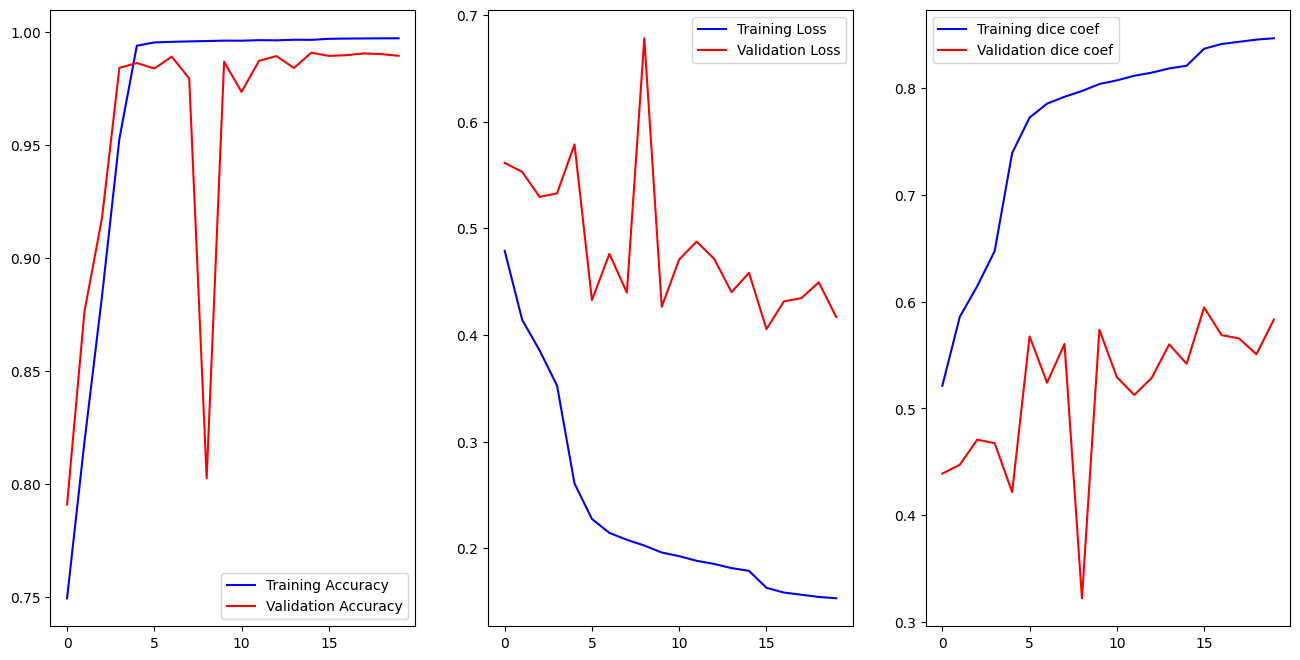

In [26]:
############ load trained model ################
model = keras.models.load_model('model_UNet_32_dice_loss.h5',
                                   custom_objects={ 'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_model_UNet_32_dice_loss.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

#ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
#ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
#ax[3].legend()

plt.show()